# E10.5 Velocity

## Loading modules

In [1]:
import pandas as pd
import glob
import scvelo as scv
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
scv.settings.set_figure_params('scvelo')
palette=['#4e79a7','#a0cbe8','#f28e2b',
         '#c3dbeb','#59a14f','#8cd17d',
         '#b6992d','#f1ce63','#499894',
         '#86bbaf','#e15759','#ff9d9a',
         '#79706e','#bab0ac']

## Obtaining data

In [2]:
adata=scv.read("ML8-11_F.h5ad")
adata.obs["leiden"]=pd.read_csv("../leiden_assigned.csv",index_col=0)["leiden"]
adata.obs.leiden=adata.obs.leiden.astype("category")
adata.obs.leiden=adata.obs.leiden.cat.reorder_categories(pd.read_csv("../leiden_colors.csv").iloc[:,0].values)

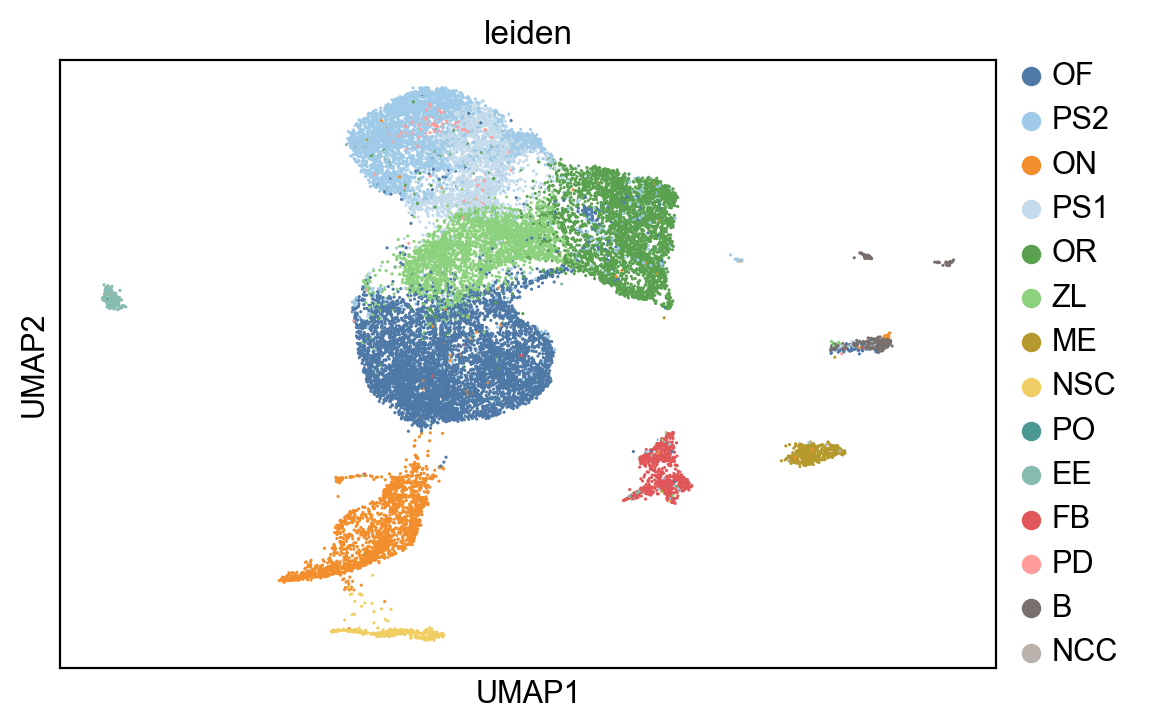

In [3]:
adata_ML10=adata[adata.obs["batch"].isin(["ML10"])]
adata_ML10.obsm["X_umap"]=pd.read_csv("../pagoda2/output/UMAP_ML10.csv",index_col=0).values
adata_ML10.uns["leiden_colors"]=palette
sc.pl.umap(adata_ML10,color="leiden",sort_order=False,cmap="Spectral_r")

## CytoTRACE calculation

In [4]:
adata_ML10_raw=adata_ML10.copy()

from cellrank.tl.kernels import CytoTRACEKernel
import scvelo as scv
def get_cytotrace(adata):
    sc.pp.filter_genes(adata, min_cells=10)
    scv.pp.normalize_per_cell(adata,enforce=True)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata)

    adata.layers["spliced"] = adata.X
    adata.layers["unspliced"] = adata.X
    scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
    ctk = CytoTRACEKernel(adata)
    
get_cytotrace(adata_ML10_raw)

Normalized count data: X, spliced, unspliced.
computing neighbors
    finished (0:00:30) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:28) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


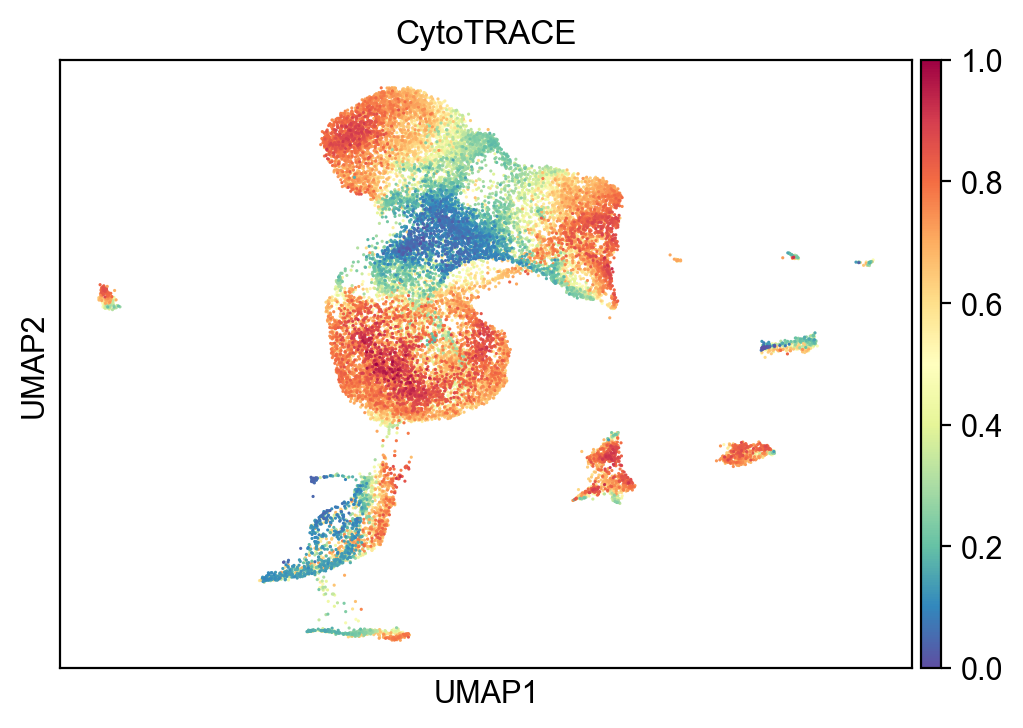

In [5]:
adata_ML10.obs["CytoTRACE"]=adata_ML10_raw.obs.ct_score
sorted_cells=(adata_ML10_raw.obs.ct_score-0.5).abs().sort_values().index
sc.pl.umap(adata_ML10[sorted_cells],color="CytoTRACE",sort_order=False,cmap="Spectral_r")

## RNA velocity estimation

In [6]:
scv.pp.filter_and_normalize(adata_ML10, min_counts=20, min_counts_u=10,n_top_genes=2000)
scv.pp.moments(adata_ML10)
scv.tl.velocity(adata_ML10)
scv.tl.velocity_graph(adata_ML10,n_jobs=40)

Filtered out 37362 genes that are detected 20 counts (spliced).
Filtered out 3691 genes that are detected 10 counts (unspliced).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:07) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:10) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 40/88 cores)


  0%|          | 0/23043 [00:00<?, ?cells/s]

/home/lfaure/miniconda3/envs/bio-gpu-18/lib/python3.8/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


    finished (0:00:19) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:06) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


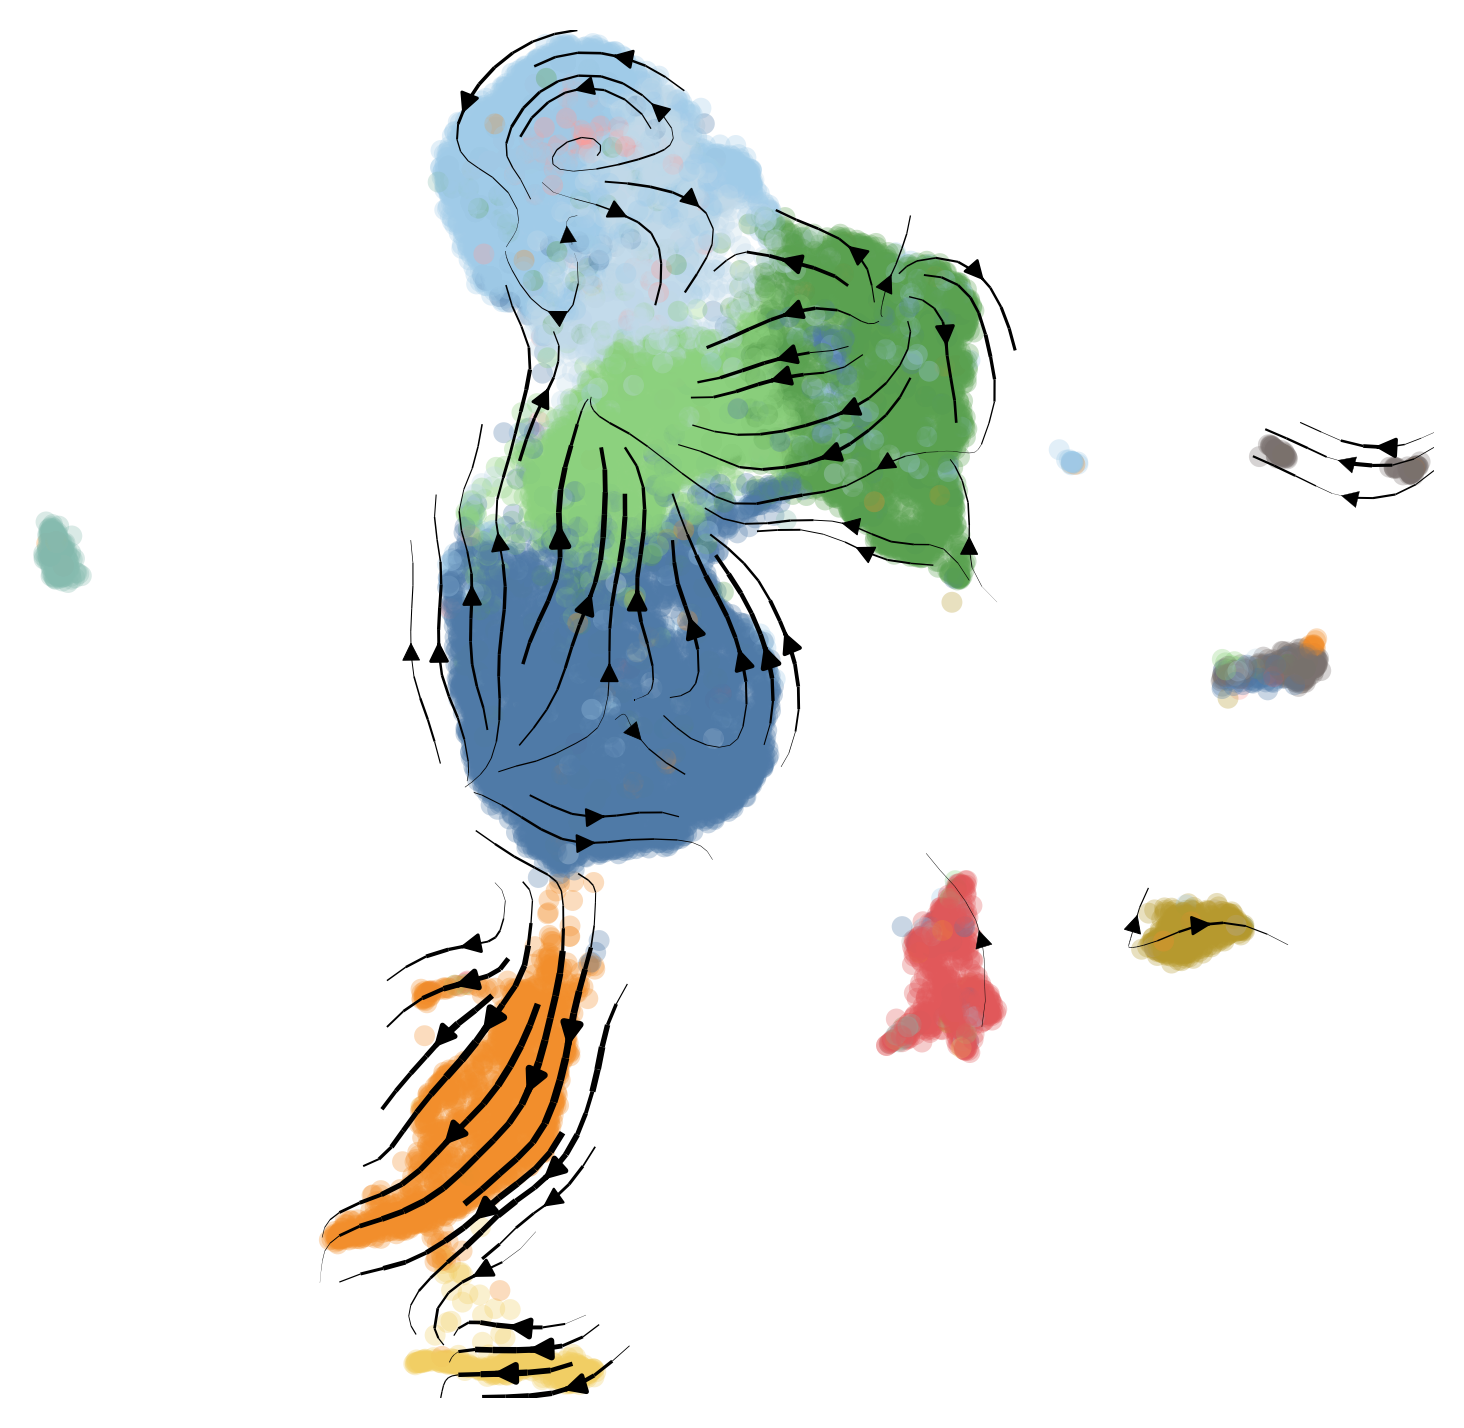

In [7]:
scv.pl.velocity_embedding_stream(adata_ML10,basis="umap",color="leiden",dpi=150,
                                 legend_loc="none",title="",figsize=[6,6])

calculating cell cycle phase
-->     'S_score' and 'G2M_score', scores of cell cycle phases (adata.obs)


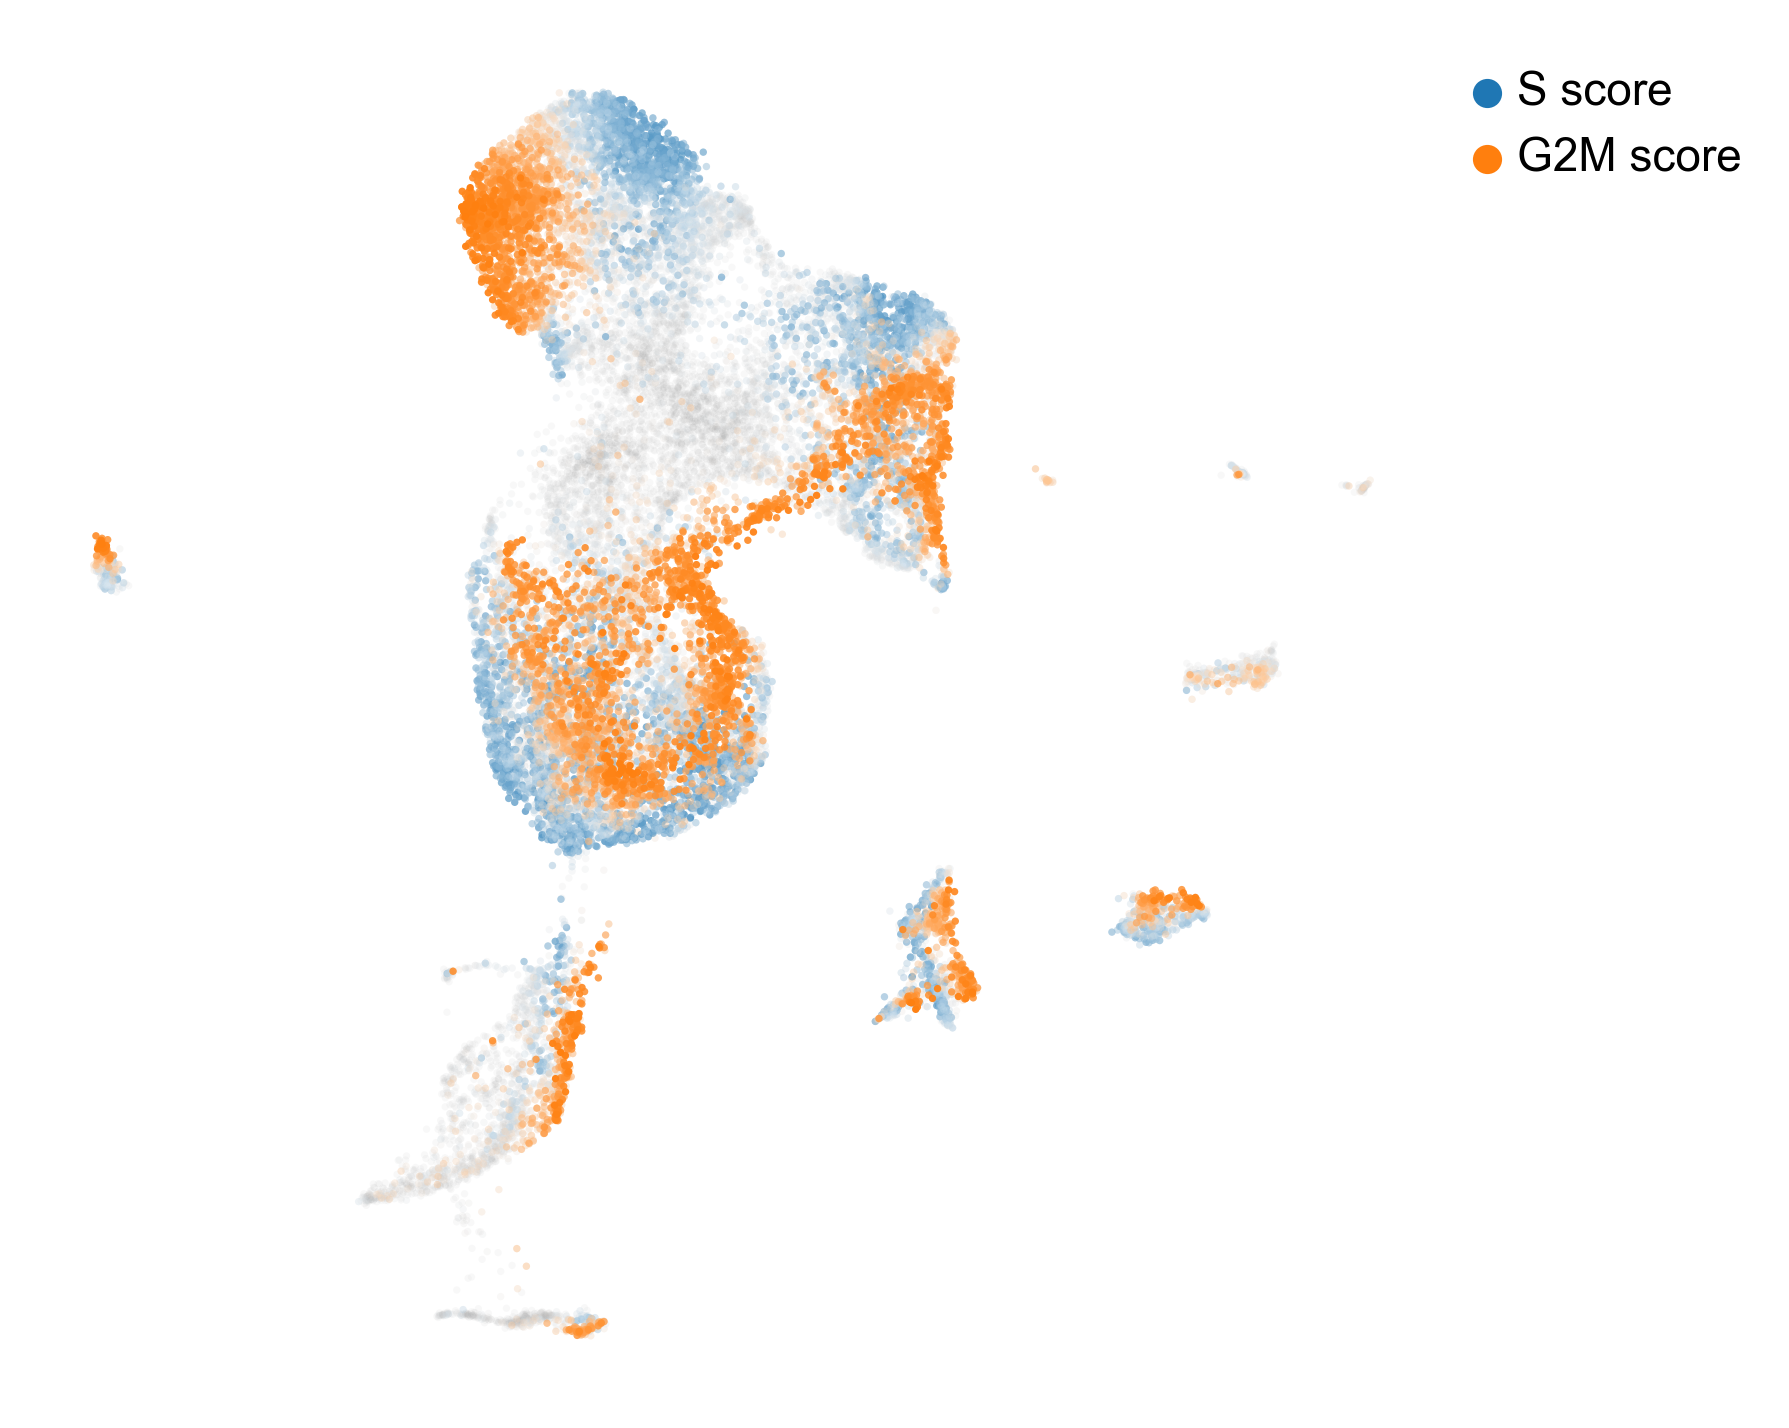

In [8]:
scv.tl.score_genes_cell_cycle(adata_ML10)

scv.pl.scatter(adata_ML10, color_gradients=['S_score', 'G2M_score'], smooth=True, perc=[5, 95],dpi=150,
              title="",figsize=[6,6])

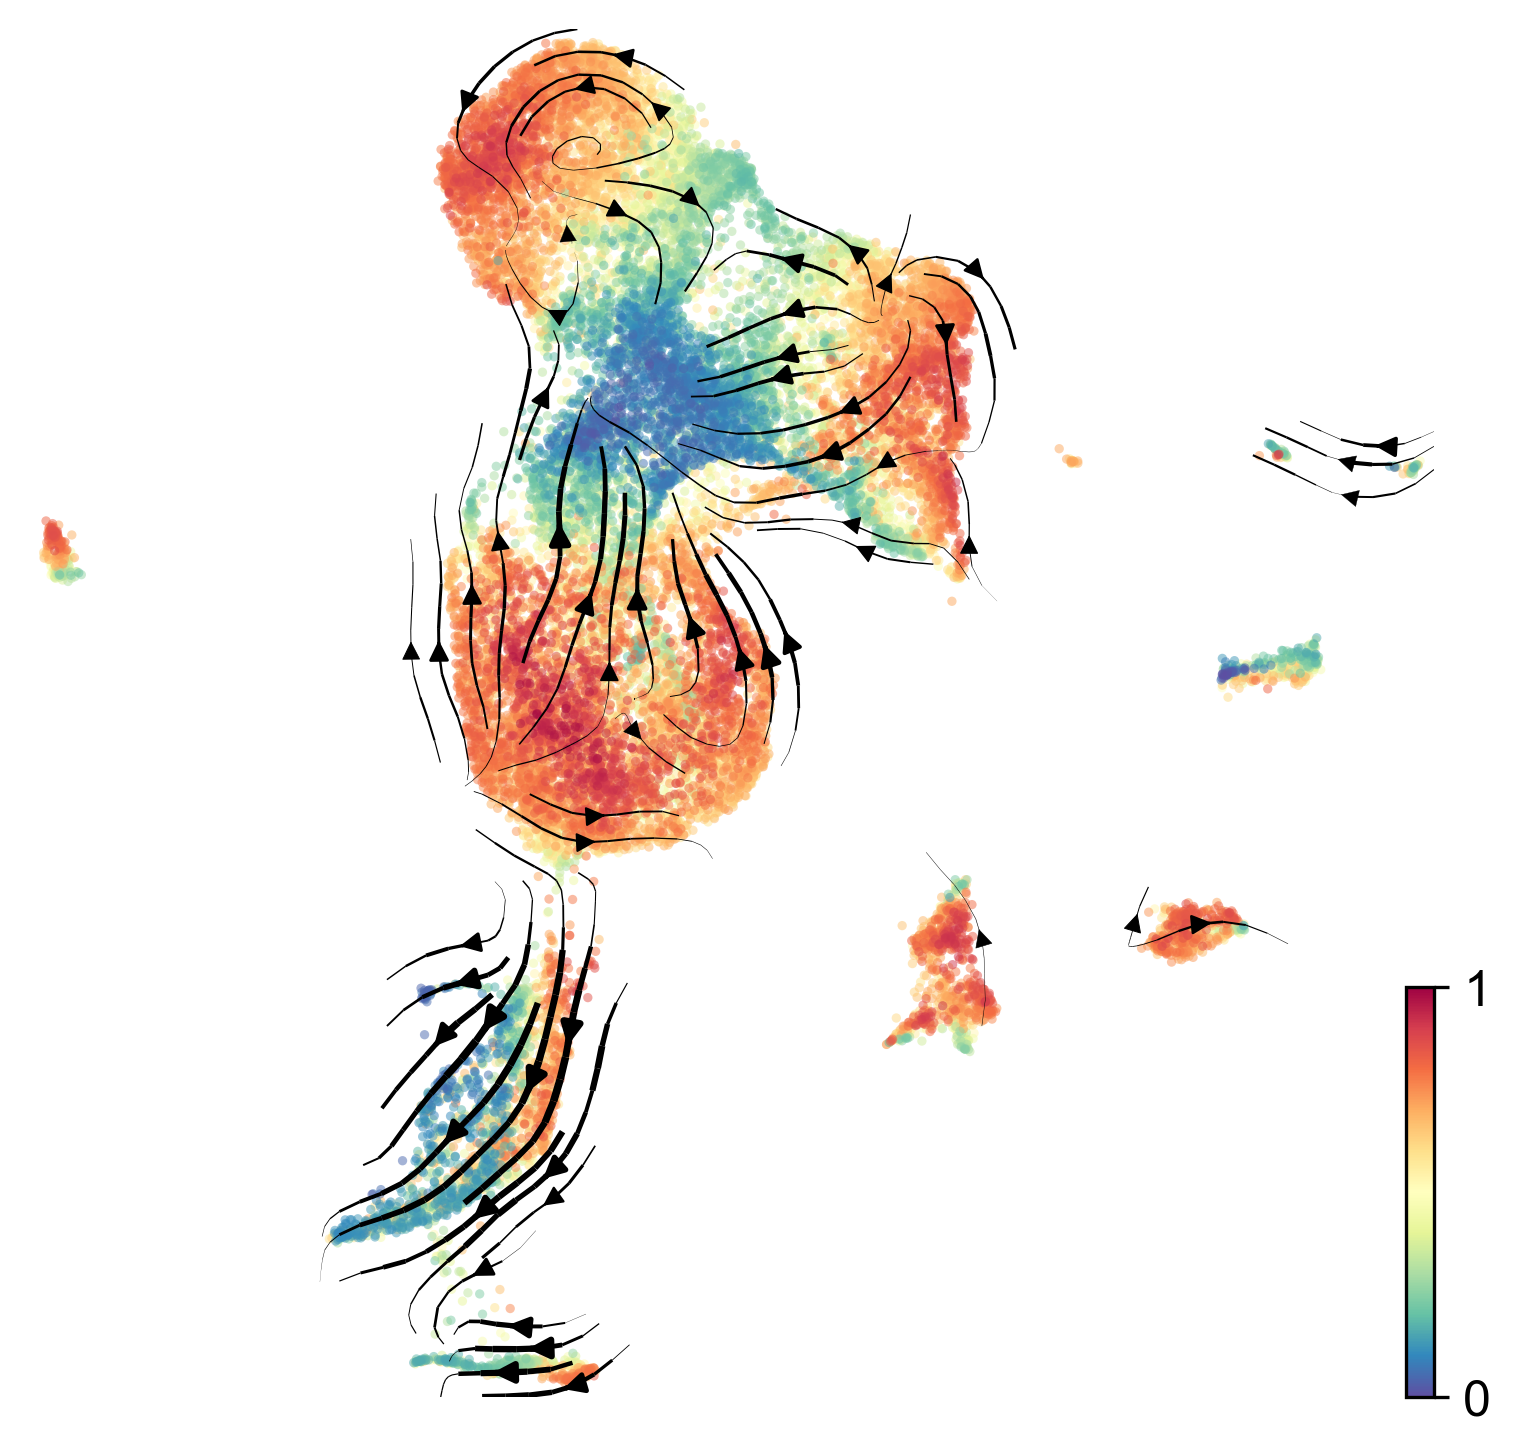

In [9]:
scv.pl.velocity_embedding_stream(adata_ML10[sorted_cells],sort_order=False,basis="umap",color="CytoTRACE",
                                 color_map="Spectral_r",dpi=150,legend_loc="none",title="",figsize=[6,6],
                                 size=20,alpha=.5)

In [10]:
scv.tl.terminal_states(adata_ML10)

computing terminal states
    identified 5 regions of root cells and 3 regions of end points .
    finished (0:00:05) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


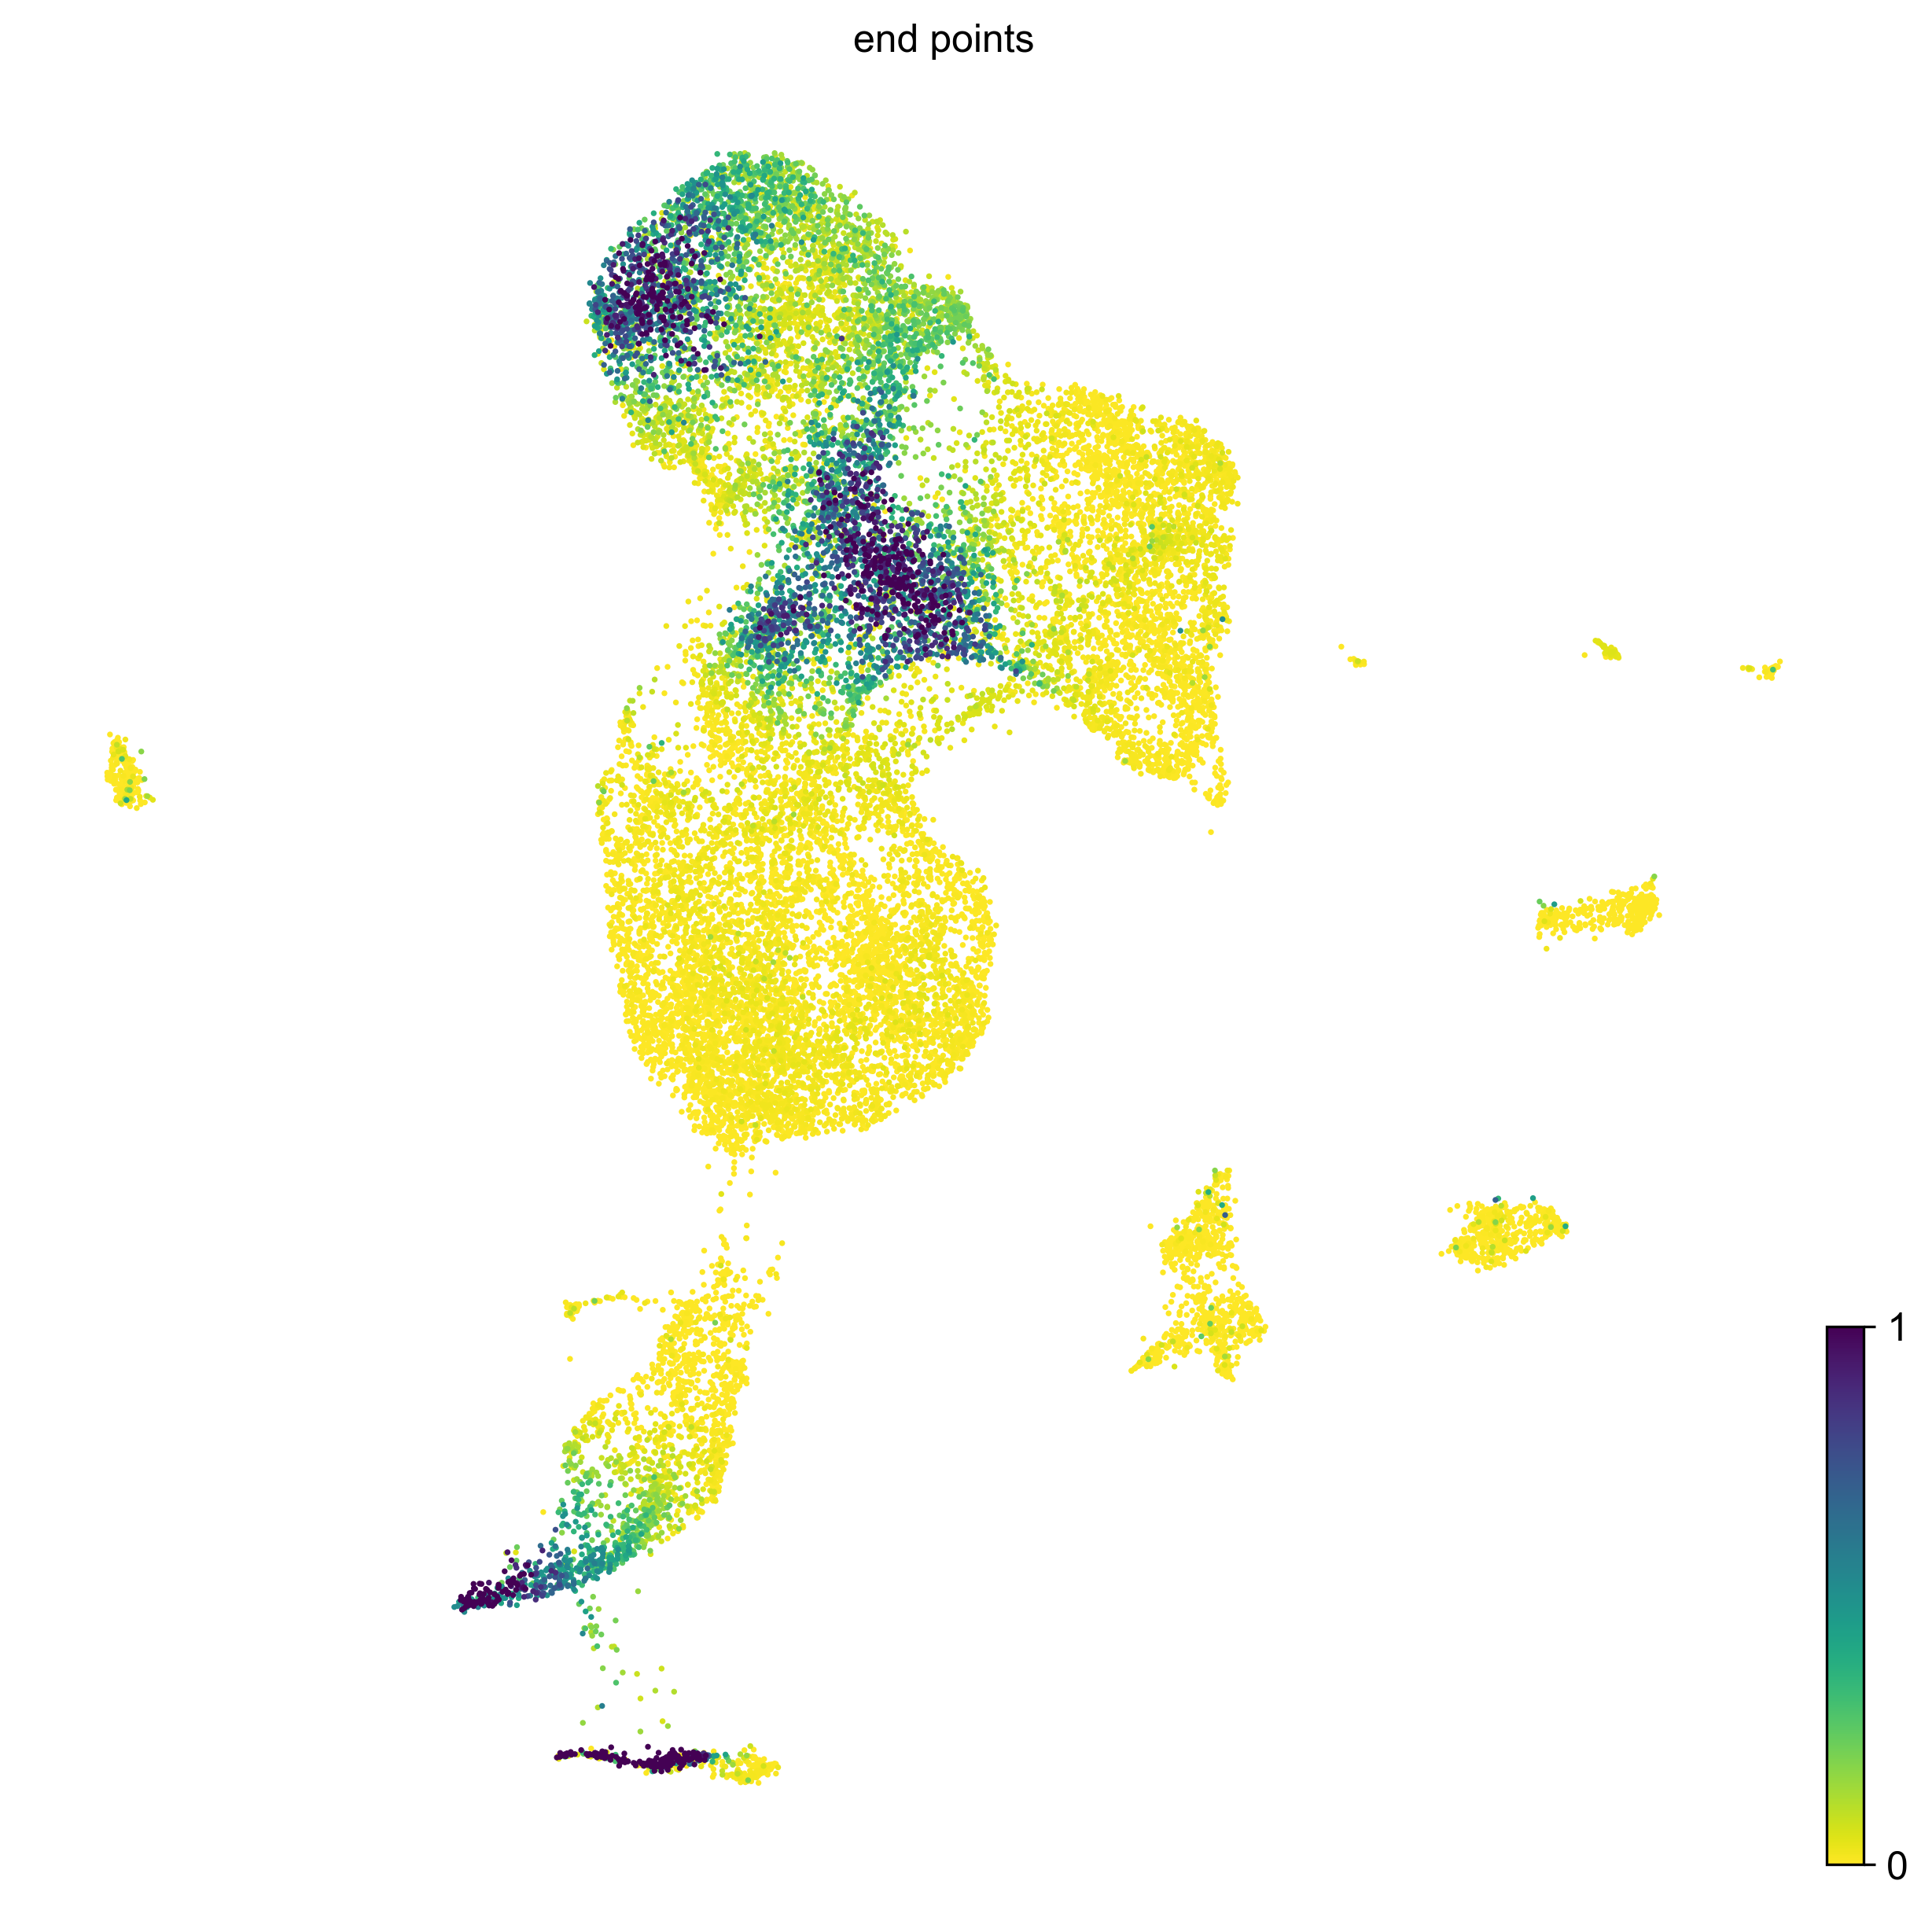

In [11]:
scv.pl.scatter(adata_ML10, color='end_points',dpi=150,figsize=[10,10])

In [12]:
adata_ML10.write_h5ad("ML10_velo.h5ad")